# Network Traffic AutoTSEstimator (customized model)

In telco, accurate forecast of KPIs (e.g. network traffic, utilizations, user experience, etc.) for communication networks ( 2G/3G/4G/5G/wired) can help predict network failures, allocate resource, or save energy. 

In this notebook, we demonstrate a reference use case where we use the network traffic KPI(s) in the past to predict traffic KPI(s) in the future. We demonstrate how to use **AutoTSEstimator** to adjust the parameters of a customized model.

For demonstration, we use the publicly available network traffic data repository maintained by the [WIDE project](http://mawi.wide.ad.jp/mawi/) and in particular, the network traffic traces aggregated every 2 hours (i.e. AverageRate in Mbps/Gbps and Total Bytes) in year 2018 and 2019 at the transit link of WIDE to the upstream ISP ([dataset link](http://mawi.wide.ad.jp/~agurim/dataset/)). 

## Helper Function

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [1]:
import matplotlib.pyplot as plt
def plot_predict_actual_values(date, y_pred, y_test, ylabel):
    """
    plot the predicted values and actual values (for the test data)
    """
    fig, axs = plt.subplots(figsize=(16, 6))

    axs.plot(date, y_pred, color='red', label='predicted values')
    axs.plot(date, y_test, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel('test datetime')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

## Prepare Dataset

We use `get_public_tsdata` to load and process the data, specify the name and path, and the ts data set will be returned. Currently we support `nyc_taxi`, `network_traffic`, `fsi`, `AIOps`.

In [2]:
from sklearn.preprocessing import StandardScaler
from bigdl.chronos.data.repo_dataset import get_public_dataset

In [3]:
name = 'network_traffic'

stand = StandardScaler()
tsdata_train, tsdata_val, \
    tsdata_test = get_public_dataset(name,
                                     with_split=True,
                                     val_ratio=0.1,
                                     test_ratio=0.1)
for tsdata in [tsdata_train, tsdata_val, tsdata_test]:
    tsdata.gen_dt_feature(one_hot_features=['HOUR', 'WEEK'])\
          .impute('last')\
          .scale(stand, fit=tsdata is tsdata_train)


## Custom Model

Regarding the model, we use torch.nn.GRU to define, More details, please refer to [here](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html?highlight=gru#torch.nn.GRU).

```python
# The input and output data should be reshaped to a 3d numpy array with the format of (batchsize, seq_len, feature_num).
out = out.view(out.shape[0], 1, out.shape[-1])
```
 Detailed information please refer to [here](https://analytics-zoo.readthedocs.io/en/latest/doc/Chronos/Overview/chronos.html#roll-sampling).

In [4]:
import torch
from torch import nn
class GRUNet(nn.Module):
    def __init__(self, input_dim, layer_num, hidden_dim, dropout, output_dim):
        super(GRUNet, self).__init__()
        self.layer_num = layer_num
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, layer_num, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_seq):
        h0 = torch.randn(self.layer_num, input_seq.size(0), self.hidden_dim)
        gru_out, _ = self.gru(input_seq, h0)
        out = self.fc(gru_out[:, -1, :])
        out = out.view(out.shape[0], 1, out.shape[-1])
        return out

Define a model creator function which returns the defined model.

In [5]:
def model_creator(config):
    return GRUNet(input_dim=config['input_feature_num'],
                  layer_num=config['layer_num'],
                  hidden_dim=config['hidden_dim'],
                  dropout=config['dropout'],
                  output_dim=config['output_feature_num'])

In [6]:
from bigdl.orca import init_orca_context
init_orca_context(cores=4, memory='10g', init_ray_on_spark=True)

Initializing orca context
Current pyspark location is : /home/liangs/spark/python/lib/pyspark.zip/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /home/liangs/analytics-zoo/zoo/target/analytics-zoo-bigdl_0.13.0-spark_2.4.6-0.12.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


2021-09-27 00:20:45,251	INFO services.py:1174 -- View the Ray dashboard at http://10.239.44.67:8265


{'node_ip_address': '10.239.44.67', 'raylet_ip_address': '10.239.44.67', 'redis_address': '10.239.44.67:6379', 'object_store_address': '/tmp/ray/session_2021-09-27_00-20-44_690221_13476/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2021-09-27_00-20-44_690221_13476/sockets/raylet', 'webui_url': '10.239.44.67:8265', 'session_dir': '/tmp/ray/session_2021-09-27_00-20-44_690221_13476', 'metrics_export_port': 64077, 'node_id': 'eb56e831d9de686ce88b515759c98d4d0c939171c3f63e2bd3546da4'}


<SparkContext master=local[4] appName=pyspark-shell>

## Search space & Initialize `AutoTSEstimator`

Define the search interval of the parameter.

In [7]:
from bigdl.orca.automl import hp
search_space={
    'hidden_dim': hp.grid_search([32, 64]),
    'layer_num': hp.grid_search([2, 4]),
    'dropout': hp.uniform(0.1, 0.2)
}

Pass the defined search space and model to `AutoTSEstimator`.

In [8]:
from bigdl.chronos.autots.autotsestimator import AutoTSEstimator
autotsest = AutoTSEstimator(model=model_creator,
                            search_space=search_space,
                            past_seq_len=15,
                            metric='mse',
                            loss=torch.nn.MSELoss(),
                            cpus_per_trial=2)

## Fit Model & Evaluate

In [9]:
%%time
ts_pipeline = autotsest.fit(data=tsdata_train,
                            epochs=5,
                            batch_size=hp.choice([32, 64]),
                            validation_data=tsdata_val)

2021-09-27 00:21:43,196	INFO tune.py:450 -- Total run time: 57.00 seconds (56.90 seconds for the tuning loop).


CPU times: user 4.78 s, sys: 828 ms, total: 5.61 s
Wall time: 58 s


In [10]:
best_config = autotsest.get_best_config()
print(best_config)

{'hidden_dim': 64, 'layer_num': 2, 'dropout': 0.16160048693372794, 'past_seq_len': 15, 'future_seq_len': 1, 'input_feature_num': 21, 'output_feature_num': 2, 'selected_features': ['HOUR_5', 'HOUR_1', 'HOUR_20', 'YEAR', 'HOUR_11', 'HOUR_9', 'HOUR_4', 'HOUR_18', 'HOUR_10', 'DAY', 'MONTH', 'HOUR_19', 'IS_WEEKEND', 'WEEKDAY', 'HOUR_13', 'HOUR_0', 'HOUR_23', 'HOUR_16', 'HOUR_17'], 'batch_size': 64}


We use `rmse` and `smape` to evaluate the results of the model.

In [11]:
rmse, smape = ts_pipeline.evaluate(tsdata_test,
                                   multioutput='raw_values',
                                   metrics=['rmse', 'smape'])
print(f'AvgRate rmse is: {rmse[0][0]}, smape is: {smape[0][0]:.4f}')
print(f'total rmse is: {rmse[0][1]}, smape is: {smape[0][1]:.4f}')

AvgRate rmse is: 58.793097944845314, smape is: 6.5279
total rmse is: 52798431522.26861, smape is: 6.5574


In [12]:
from bigdl.orca.common import stop_orca_context
stop_orca_context()

Stopping orca context


## Visualization

In [13]:
# predict
yhat = ts_pipeline.predict(tsdata_test)

# y_true
x_test, y_test = tsdata_test.roll(lookback=best_config['past_seq_len'],
                                  horizon=1).to_numpy()
unscale_y_test = tsdata_test.unscale_numpy(y_test)

# Timeline
test_date = tsdata_test.df.StartTime.reset_index(drop=True)[:-best_config['past_seq_len']]

Plot actual and prediction values for `total` KPI.

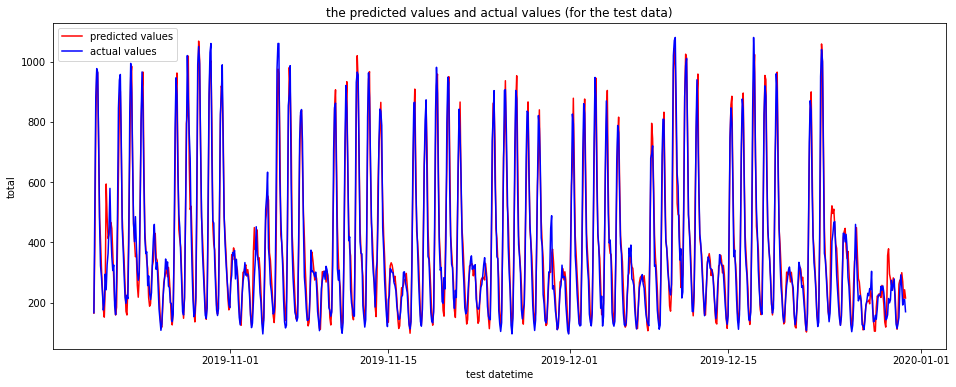

In [14]:
target_name = 'total'
plot_predict_actual_values(test_date,
                           y_pred=yhat[:-1, 0, 0],
                           y_test=unscale_y_test[:, 0, 0],
                           ylabel=target_name)

Plot actual and prediction values for `AvgRate` KPI.

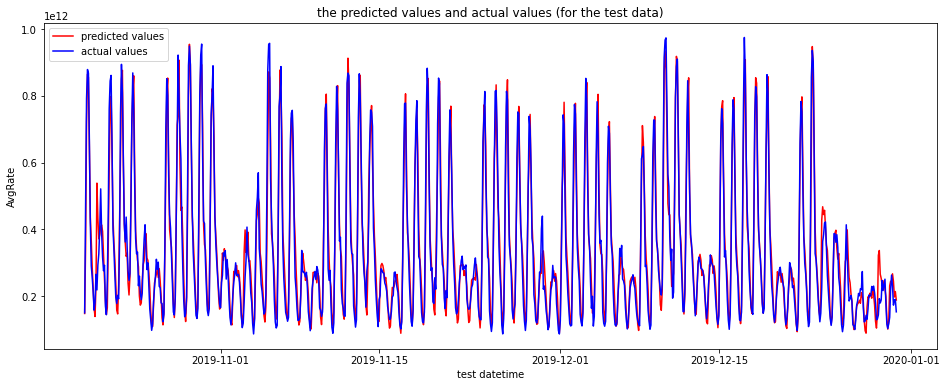

In [15]:
target_name = 'AvgRate'
plot_predict_actual_values(test_date,
                           y_pred=yhat[:-1, 0, 1],
                           y_test=unscale_y_test[:, 0, 1],
                           ylabel=target_name)